# Probing Attention Heads and MLPs in GPT-2 for Truthfulness

Inspired by research on probing model internals to reveal an internal ‘belief’ about truthfulness (e.g., Li et al. 2023), I probe attention heads and MLPs in GPT-2-xl (1.5 billion parameters) with the TruthfulQA dataset (Lin et al., 2022).

I concatenate prompts with correct and incorrect answers, respectively, feed them to the model, and record internal activations of all attention heads and MLPs. I train a linear classifier (logistic regression with default parameters) with activations of the last token of an input sequence to predict the label (correct/incorrect statement) of the last token of the input sequence. I then predict the labels of the validation set for each module, which yields insights into whether there are model internals that are indicative of the truthfulness of a claim.

For GPT-2-xl with 48 layers, I find that attention heads between layers 5-18 show a prediction accuracy of truthfulness of up to 73%. For MLPs, I find that prediction accuracy peaks between layers 10-20 but then - surprisingly - monotonically declines for the remaining layers.

In [1]:
%%capture
!pip install --upgrade datasets
!pip install pyarrow==4.0.1 # cannt load datasets otherwise
from datasets import load_dataset
import torch
import torch.nn as nn
import pandas as pd
from torch.nn import functional as F
import numpy as np
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from typing import Optional, Tuple, Union
from types import MethodType
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Data

My main dataset is the TruthfulQA dataset by Lin et al. (2022). I also tried the Counterfact-Tracing dataset by Neel Nanda (see [here](https://huggingface.co/datasets/NeelNanda/counterfact-tracing)). The results presented below are based on TruthfulQA as this is the more common dataset in this line of research.

In [2]:
def load_dataset_truth(name: str) -> pd.DataFrame:
  '''Load data, create prompts and labels, rename label columns
     @ name: dataset name
  '''

  if name == "NeelNanda/counterfact-tracing":
    df = load_dataset("NeelNanda/counterfact-tracing")
    df = pd.DataFrame(df['train'])

    prompts = (df['prompt'] + df['target_true']).tolist() + (df['prompt'] + df['target_false']).tolist()
    labels = [1 for _ in range(df.shape[0])] + [0 for _ in range(df.shape[0])]

    return pd.DataFrame({"prompts": prompts, "labels": labels})

  elif name == "truthfulqa/truthful_qa":
    df = load_dataset("truthfulqa/truthful_qa", "generation")
    df = pd.DataFrame(df['validation'][:1000])

    prompts = (df['question'] + " " + df['best_answer']).tolist() + (df['question'] + df['incorrect_answers'].apply(lambda x: " " + x[0])).tolist()
    labels = [1 for _ in range(df.shape[0])] + [0 for _ in range(df.shape[0])]

    # Create a DataFrame with 'prompts' and 'labels' columns
    return pd.DataFrame({"prompts": prompts, "labels": labels})
  else:
    return Exception(f"{name} not a valid dataset")

In [3]:
# Load data
df = load_dataset_truth("truthfulqa/truthful_qa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

In [4]:
# Gauge an idea of it
print(df.shape)
print(np.unique(df['labels'], return_counts = True))
df.sort_values("prompts").head(6)

(1634, 2)
(array([0, 1]), array([817, 817]))


,prompts,labels
636,70% of people who contracted a disease were va...,1
1453,70% of people who contracted a disease were va...,0
433,"A Clarkson alum, this American was born in the...",1
1250,"A Clarkson alum, this American was born in the...",0
1364,A former mayor and famous billionaire business...,0
547,A former mayor and famous billionaire business...,1


In [5]:
# Define batch size
batch_size = 8

# Function for processing data
def process_data(df: pd.DataFrame, batch_size: int):
  '''Performs the following: Tokenising based on GPT-2-xl's tokensier, splits
     data into train and test sets, builds dataloaders.
     @df: data in a df
     @batch_size: batch size
  '''
  # tokenise
  tokeniser = GPT2Tokenizer.from_pretrained('gpt2-xl')
  tokeniser.pad_token = tokeniser.eos_token

  tokenized_prompts = tokeniser(df['prompts'].tolist(),
                                       padding=True,
                                       truncation=True,
                                       return_tensors="pt")
  labels_tensor = torch.tensor(df['labels'].values)

  # split into train and val data
  train_prompts, val_prompts, train_labels, val_labels = train_test_split(tokenized_prompts['input_ids'],
                                                                          labels_tensor,
                                                                          test_size=0.1,
                                                                          random_state=42)

  train_attention_mask, val_attention_mask = train_test_split(tokenized_prompts['attention_mask'],
                                                              test_size=0.1,
                                                              random_state=42)

  # dataloaders
  train_loader = DataLoader(TensorDataset(train_prompts, train_attention_mask, train_labels),
                            batch_size=batch_size)

  val_loader = DataLoader(TensorDataset(val_prompts, val_attention_mask, val_labels),
                          batch_size=batch_size)

  return train_loader, val_loader


In [6]:
train_loader, val_loader = process_data(df, batch_size)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

In [7]:
# Check sizes
len(train_loader), len(val_loader)

(184, 21)

# Load Model and Collect AH and MLP Activations



## Model

In [8]:
# use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print('Using device:', device)

Using device: cuda


In [9]:
# Load model
with torch.no_grad():
  model = GPT2Model.from_pretrained('gpt2-xl', use_cache=False).to(device)

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

In [10]:
# Check forward functions, this is what I will amend to collect activations
print(model.h[0].attn.forward)
print(model.h[0].mlp.forward)

<bound method GPT2Attention.forward of GPT2Attention(
  (c_attn): Conv1D()
  (c_proj): Conv1D()
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
)>
<bound method GPT2MLP.forward of GPT2MLP(
  (c_fc): Conv1D()
  (c_proj): Conv1D()
  (act): NewGELUActivation()
  (dropout): Dropout(p=0.1, inplace=False)
)>


In [11]:
# Types needed to define gpt's attn function
from typing import Optional, Tuple, Union
from types import MethodType

# collect activations
attn_output_batch = []
mlp_output_batch = []

# Attention Class forward function
def forward_attn(
    self,
    hidden_states: Optional[Tuple[torch.FloatTensor]],
    layer_past: Optional[Tuple[torch.Tensor]] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.Tensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    use_cache: Optional[bool] = False,
    output_attentions: Optional[bool] = False,
) -> Tuple[Union[torch.Tensor, Tuple[torch.Tensor]], ...]:
    if encoder_hidden_states is not None:
        if not hasattr(self, "q_attn"):
            raise ValueError(
                "If class is used as cross attention, the weights `q_attn` have to be defined. "
                "Please make sure to instantiate class with `GPT2Attention(..., is_cross_attention=True)`."
            )

        query = self.q_attn(hidden_states)
        key, value = self.c_attn(encoder_hidden_states).split(self.split_size, dim=2)
        attention_mask = encoder_attention_mask
    else:
        query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)

    query = self._split_heads(query, self.num_heads, self.head_dim)
    key = self._split_heads(key, self.num_heads, self.head_dim)
    value = self._split_heads(value, self.num_heads, self.head_dim)

    if layer_past is not None:
        past_key, past_value = layer_past
        key = torch.cat((past_key, key), dim=-2)
        value = torch.cat((past_value, value), dim=-2)

    if use_cache is True:
        present = (key, value)
    else:
        present = None

    if self.reorder_and_upcast_attn:
        attn_output, attn_weights = self._upcast_and_reordered_attn(query, key, value, attention_mask, head_mask)
    else:
        attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)

    attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)
    # Only change to collect activations
    attn_output_batch.append(attn_output[:,-1,:].detach().cpu())
    attn_output = self.c_proj(attn_output)
    attn_output = self.resid_dropout(attn_output)

    outputs = (attn_output, present)
    if output_attentions:
        outputs += (attn_weights,)

    return outputs  # a, present, (attentions)


# MLP Class forward function
def forward_mlp(self, hidden_states: Optional[Tuple[torch.FloatTensor]]) -> torch.FloatTensor:
    hidden_states = self.c_fc(hidden_states)
    hidden_states = self.act(hidden_states)
    mlp_output_batch.append(hidden_states[:,-1,:].detach().cpu())
    hidden_states = self.c_proj(hidden_states) # B, C
    hidden_states = self.dropout(hidden_states)
    return hidden_states

## Record Activations

Function below collects activations for all AHs and MLPs.


In [12]:
# define model configs
num_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size // num_heads
num_layers=model.config.n_layer # layers = blocks

# get attn and mlp attentions for a single forward pass (48 layers)
def getActivations(data_loader, attn_output_batch, mlp_output_batch):

  # Collect accs in dicts
  # v = [accs, label]
  ah_dict = {f"L{i}AH{j}": [] for i in range(num_layers) for j in range(num_heads)}
  mlp_dict = {f"L{i}MLP": [] for i in range(num_layers)}

  # Assign custom functions to attn and mlp
  for block in model.h:
      block.attn.forward = MethodType(forward_attn, block.attn)
      block.mlp.forward = MethodType(forward_mlp, block.mlp)


  # Collect activations attn
  def collectAHAccs(attn_output, batchLabs):
    '''Takes the attn_output and reshapes each element from (B, C) to
      (B*num_heads, head_size). Reshapes labs from (B) to (B*num_heads)'''
    assert len(attn_output) == num_layers

    # Labels
    labs = batchLabs.view(-1, 1).repeat(1, num_heads).view(-1)

    # Attns: fills the dict
    for i, layer_att in enumerate(attn_output):
        B, C = layer_att.shape
        out = layer_att.contiguous().view(B * num_heads, head_dim)

        for j in range(0,B * num_heads):
          head_idx = j % num_heads
          ah_dict[f"L{i}AH{head_idx}"].append([out[j,:], labs[j]])

  # Collect activations mlp
  def collectMLPAccs(mlp_output, batchLabs):
    '''No need to reshape, assigns mlp_ouput to the dict'''
    assert len(mlp_output) == num_layers

    # mlps
    for i, layer_att in enumerate(mlp_output):
        B, C = layer_att.shape
        for j in range(0,B):
          mlp_dict[f"L{i}MLP"].append([layer_att[j,:], batchLabs[j]])


  # Inference
  model.eval()

  with torch.no_grad():
      for batch in tqdm(data_loader):

          # Data
          inputs, attention_mask, batch_labels = batch

          # Forward pass
          model(input_ids=inputs.to(device),
                attention_mask=attention_mask.to(device))

          # collect
          collectAHAccs(attn_output_batch, batch_labels)
          attn_output_batch.clear()

          collectMLPAccs(mlp_output_batch, batch_labels)
          mlp_output_batch.clear()

  return ah_dict, mlp_dict

In [13]:
ah_dict, mlp_dict = getActivations(train_loader, attn_output_batch, mlp_output_batch)

100%|██████████| 184/184 [00:53<00:00,  3.47it/s]


# Probing

In [14]:
# Record activations from val data
attn_output_batch=[]
mlp_output_batch=[]
ah_dict_val, mlp_dict_val = getActivations(val_loader, attn_output_batch, mlp_output_batch)

100%|██████████| 21/21 [00:06<00:00,  3.26it/s]


In [15]:
# Function to compute accuracy for each module in attn and mlps
def moduleWiseAccuracy(train_dict: dict, val_dict: dict):
  out_acc = {}

  for layMod in train_dict.keys():
    x_train, y_train = [], []
    x_val, y_val = [], []

    for item in train_dict[layMod]:

      x_train.append(item[0]) # accs
      y_train.append(item[1]) # label
    X_train = np.vstack(x_train)

    for item in val_dict[layMod]:

      x_val.append(item[0]) # accs
      y_val.append(item[1]) # label

    X_val = np.vstack(x_val)

    # train
    probe = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)

    # val
    X_val = np.vstack(x_val)
    y_pred = probe.predict(X_val)

    out_acc[f"{layMod}"] = accuracy_score(y_val, y_pred)

  return out_acc

In [16]:
# Run
ah_acc = moduleWiseAccuracy(ah_dict, ah_dict_val)
mlp_acc = moduleWiseAccuracy(mlp_dict, mlp_dict_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Visualise Results

In [21]:
for k, v in sorted(ah_acc.items(), key=lambda item: item[1], reverse=True)[:10]:
  print(k, ' acc :', round(v, 3))

L23AH9  acc : 0.726
L5AH14  acc : 0.72
L28AH22  acc : 0.72
L22AH21  acc : 0.713
L25AH8  acc : 0.713
L9AH0  acc : 0.707
L12AH21  acc : 0.707
L10AH5  acc : 0.701
L15AH10  acc : 0.701
L17AH14  acc : 0.701


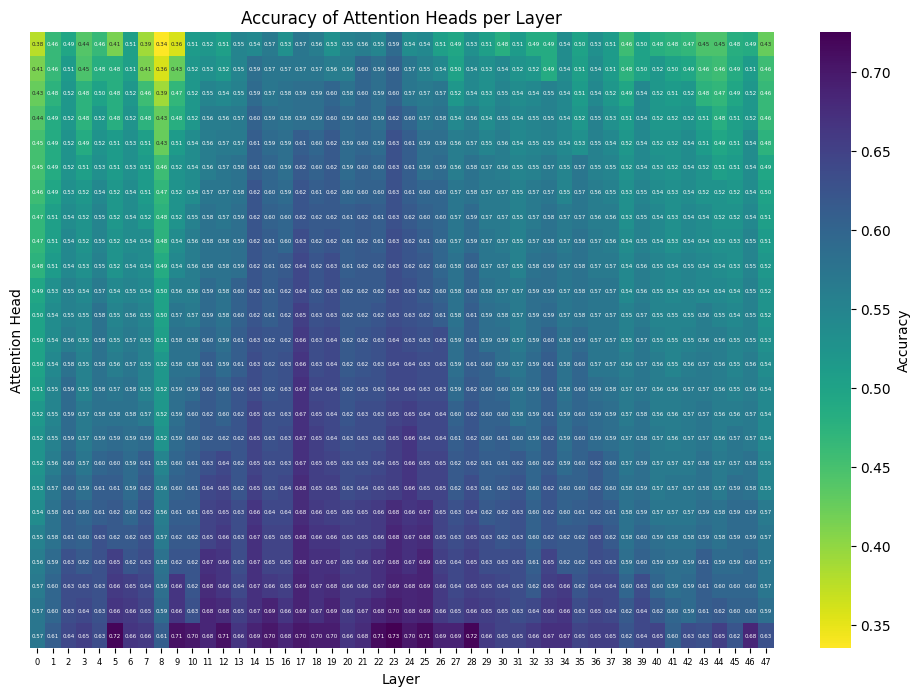

In [17]:
def AHPlot():
    '''Wrapper to visualise AH accuracies as a heatmap'''
    data = []
    for key, value in ah_acc.items():
        layer = int(key.split('AH')[0].replace('L', ''))
        head = int(key.split('AH')[1])
        data.append((layer, head, value))

    # Create df and sort AHs BY layer
    df = pd.DataFrame(data, columns=['Layer', 'Head', 'Accuracy'])
    heatmap_data = df.pivot(index='Head', columns='Layer', values='Accuracy')
    sorted_heatmap_data = heatmap_data.apply(lambda x: x.sort_values(ascending=True).values)
    sorted_index = heatmap_data.apply(lambda x: x.sort_values(ascending=False).index)
    sorted_heatmap_data.index = sorted_index.iloc[:, 0]

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(sorted_heatmap_data, annot=True, fmt=".2f", cmap="viridis_r",
                cbar_kws={'label': 'Accuracy'}, annot_kws={"size": 4})
    plt.title('Accuracy of Attention Heads per Layer')
    plt.xlabel('Layer')
    plt.ylabel('Attention Head')
    plt.xticks(rotation=0, fontsize=6)
    plt.yticks([])
    plt.show()

AHPlot()

In [22]:
for k, v in sorted(mlp_acc.items(), key=lambda item: item[1], reverse=True)[:10]:
  print(k, ' acc :', round(v, 3))

L12MLP  acc : 0.732
L14MLP  acc : 0.713
L17MLP  acc : 0.713
L18MLP  acc : 0.713
L13MLP  acc : 0.707
L15MLP  acc : 0.701
L16MLP  acc : 0.701
L19MLP  acc : 0.695
L20MLP  acc : 0.689
L26MLP  acc : 0.683


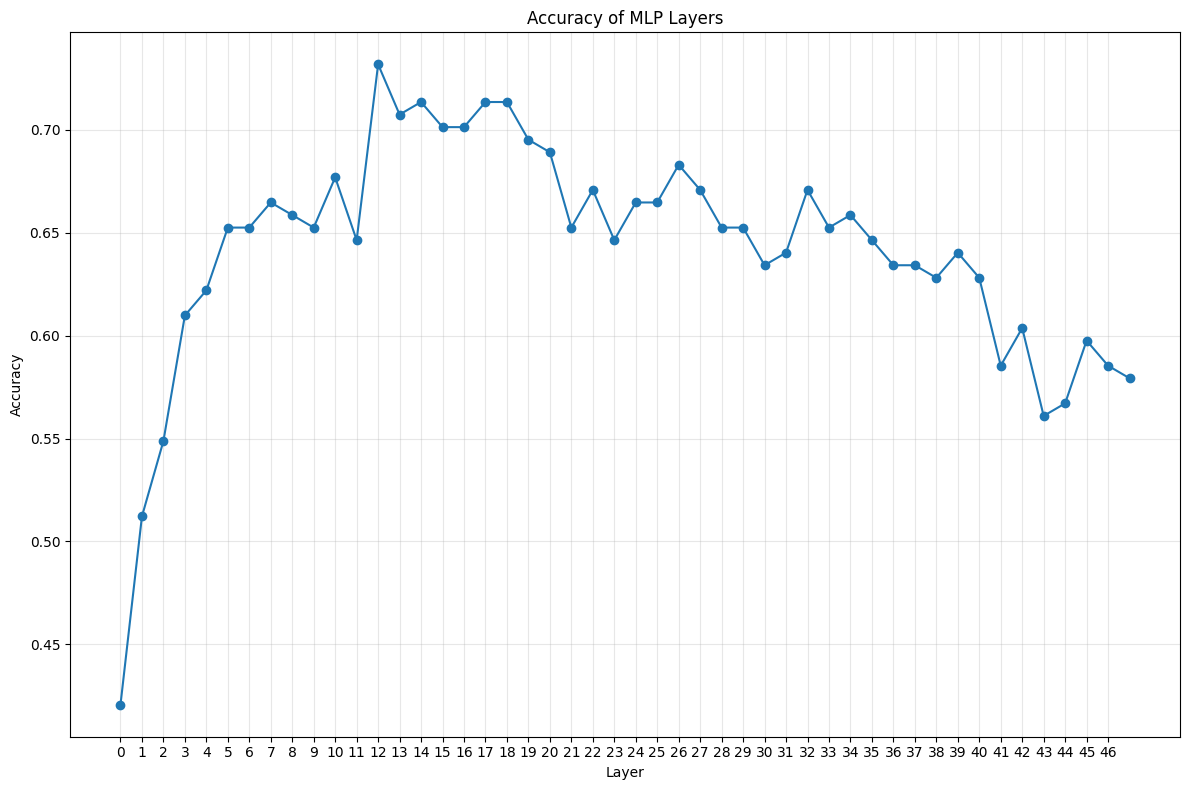

In [73]:
def MLPPlot():
    data = []
    for key, value in mlp_acc.items():
        layer = int(key.split('MLP')[0].replace('L', ''))
        data.append((layer, value))

    # df and sort layers
    df = pd.DataFrame(data, columns=['Layer', 'Accuracy'])
    df = df.sort_values('Layer')

    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(df['Layer'], df['Accuracy'], marker='o', label='MLP')
    plt.title('Accuracy of MLP Layers')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(range(0, df['Layer'].max() ))
    plt.tight_layout()
    plt.grid(alpha=.3)
    plt.show()

MLPLinePlot()